In [1]:
import serial
import serial.tools.list_ports
import time
import json
import io
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from PIL import Image

In [2]:
batch_size = 32
img_height = 32
img_width = 32
img_channel = 3
color_mode="rgb"

In [3]:
data_dir = pathlib.Path("../train/data/dataset2")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               color_mode=color_mode)

print(train_ds.class_names)

Found 1384 files belonging to 4 classes.
Using 1108 files for training.
['cloudy', 'rain', 'shine', 'snow']


2022-03-23 20:44:16.509126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
with np.load('../train/mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255
y_train = keras.utils.to_categorical(y_train)

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [5]:
ports = serial.tools.list_ports.comports()

for __port in ports:
    print(__port.name)

cu.wlan-debug
cu.Bluetooth-Incoming-Port
cu.usbmodem1101


In [6]:
port = serial.Serial("/dev/cu.usbmodem1101", baudrate=115200, timeout=1)

In [7]:
port.read_all()

b''

In [8]:
img_size = img_width * img_height * img_channel * 4
command = {"command":0, "ds":img_size, "repeat": 1}
command_json = json.dumps(command)
print(command_json)

command_json += "\n"
port.write(command_json.encode())
time.sleep(0.1)

print(port.read_all())

{"command": 0, "ds": 12288, "repeat": 1}
b'{"payload":"[1] Received {\\"command\\": 0, \\"ds\\": 12288, \\"repeat\\": 1}\\n\\n","type":0}\r\n{"payload":"[2] Received command with type: 0\\n","type":0}\r\n{"payload":"[2] New state: 3\\n","type":0}\r\n'


In [375]:
port.close()
port.open()

In [9]:
def convert_float_list_to_bytes(data):
    data_bytes = []
    for dat in data:
        bytes_ = list(struct.pack("!f", dat))
        bytes_.reverse()
        data_bytes.extend(bytes_)

    return data_bytes

In [97]:
command = {"command":0, "ds":12, "repeat": 1}
command_json = json.dumps(command)
print(command_json)

command_json += "\n"
port.write(command_json.encode())
time.sleep(0.5)

print(port.read_all())

data = np.array([[[1.123, 2.123, 3.123]]]).astype(dtype=np.float32).reshape(3)
print("Type:", data.dtype)
dat_bytes = convert_float_list_to_bytes(data)

print(dat_bytes)

port.write(dat_bytes)

time.sleep(0.5)

print(port.read_all())

{"command": 0, "ds": 12, "repeat": 1}
b'{"payload":"[2] New state: 5\\n","type":0}\r\n{"payload":{"data":[{"probabilities":[2.337613582611084,9.016510009765625,3.840365171432495,14.025681495666504,6.511923789978027],"time_us":1015023}]},"type":1}\r\n{"payload":"[2] New state: 2\\n","type":0}\r\n{"payload":"[1] Received {\\"command\\": 0, \\"ds\\": 12, \\"repeat\\": 1}\\n\\n","type":0}\r\n{"payload":"[2] Received command with type: 0\\n","type":0}\r\n{"payload":"[2] New state: 3\\n","type":0}\r\n'
Type: float32
[119, 190, 143, 63, 59, 223, 7, 64, 59, 223, 71, 64]
b'{"payload":"[2] Received data\\n","type":0}\r\n{"payload":"[2] 1.123000","type":0}\r\n{"payload":"[2] 2.123000","type":0}\r\n{"payload":"[2] 3.123000","type":0}\r\n{"payload":"[2] New state: 4\\n","type":0}\r\n'


(32, 32, 3)
(3072,)
12288


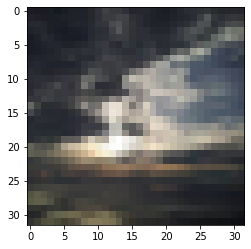

In [260]:
image_plain = Image.open("../train/data/dataset2/cloudy/cloudy44.jpg").resize((img_width, img_height), Image.ANTIALIAS)
print(np.shape(image_plain))
image = np.float32(image_plain).reshape(img_width * img_height * img_channel)
print(np.shape(image))
image_bytes = convert_float_list_to_bytes(image)
print(len(image_bytes))

plt.imshow(image_plain)

In [ ]:
k = 2
image = np.float32(x_train[k])
image = image.reshape(28*28,)
print(np.shape(image))
image_bytes = convert_float_list_to_bytes(image)
print(len(image_bytes))

In [378]:
port.write(image_bytes)

time.sleep(10)

timing_samples = []

while(True):
    lineData = port.readline()
    line = str(lineData)

    if len(lineData) == 0:
        break

    lineJsonData = io.BytesIO(lineData)
    lineJson = json.load(lineJsonData)
    print(lineJson)

    if lineJson["type"] == 1:
        data = lineJson["payload"]["data"]
        for sample in data:
            timing_samples.append(sample["time_us"])
            #print(sample["time_us"])

        
        #print(lineJson)

timing_samples = np.array(timing_samples)

pd.DataFrame(timing_samples).describe()

{'payload': '[2] Received data\n', 'type': 0}
{'payload': '[2] New state: 4\n', 'type': 0}
{'payload': '[2] New state: 5\n', 'type': 0}
{'payload': {'data': [{'probabilities': [0.9921875, 0.00390625, 0.0, 0.0], 'time_us': 348960}]}, 'type': 1}
{'payload': '[2] New state: 2\n', 'type': 0}


,0
count,1.0
mean,348960.0
std,NaN
min,348960.0
25%,348960.0
50%,348960.0
75%,348960.0
max,348960.0


In [ ]:
t_without_p = pd.DataFrame(timing_samples)
t_without_p.boxplot()

In [ ]:
t_without_p.describe()

In [ ]:
t_with_p = pd.DataFrame(timing_samples)
t_with_p.boxplot()

In [ ]:
t_with_p.describe()

## Test image send

In [ ]:
def predict_on_pi(image):
    image_bytes = convert_float_list_to_bytes(image)
    port.write(image_bytes)
    reportData = port.readall()
    reportDataIO = io.BytesIO(reportData)
    reportJson = json.load(reportDataIO)
    return reportJson

In [86]:
k = 0
image = np.float32(x_train[k])
image = image.reshape(28*28,)
predict_on_pi(image)
print("Shape:", np.shape(image))
print("Type:", image.dtype)
print("Ground trouth:", y_train[k])


NameError: name 'x_train' is not defined

## Measure timing

In [ ]:
port.close()
port.open()

In [ ]:
timing_samples = []
k = 0
image = np.float32(x_train[k])
image = image.reshape(28*28,)

cycles = 30
for cycle in range(cycles):
    report = predict_on_pi(image)
    timing_samples.append(report["timing"])
    print(cycle + 1, "/", cycles)

timing_samples = np.array(timing_samples)

In [ ]:
pd.DataFrame(timing_samples).describe()

In [ ]:
pd.DataFrame(timing_samples).describe()